15.5


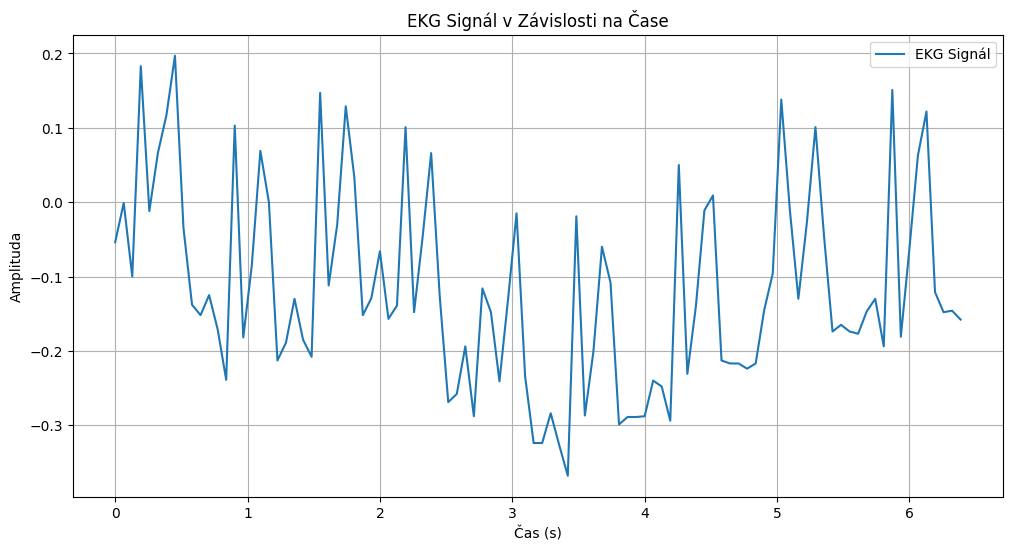

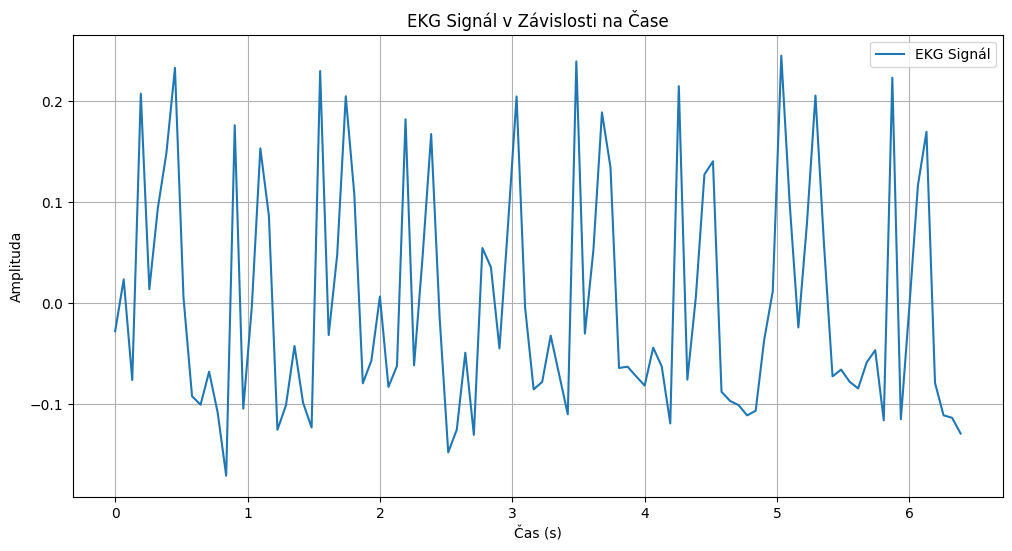

[-0.02834769  0.02297352 -0.07665539  0.20677956  0.01325776  0.09372438
  0.14809217  0.23224439  0.00503895 -0.0926865  -0.10110869 -0.06841221
 -0.10878268 -0.17139976  0.17556961 -0.10502232 -0.00429838  0.15264848
  0.08575903 -0.12598951 -0.10158214 -0.042966   -0.09905178 -0.12371641
  0.22919293 -0.03214624  0.04746215  0.20422592  0.10735725 -0.07993497
 -0.05745279  0.00598338 -0.08347207 -0.06269614  0.18139769 -0.06214451
  0.04568017  0.16683031 -0.01577968 -0.14827781 -0.12583137 -0.04964251
 -0.13094255  0.05401468  0.03496031 -0.04538164  0.07671407  0.20398218
 -0.00482512 -0.08593068 -0.07852573 -0.03276421 -0.07175828 -0.11057521
  0.23876435 -0.03071345  0.05206306  0.18820832  0.13387552 -0.06474873
 -0.06345066 -0.0729964  -0.08213963 -0.0446295  -0.06321854 -0.11967036
  0.21423316 -0.0763145   0.00584997  0.12685541  0.13979316 -0.08828469
 -0.09736554 -0.1014752  -0.11167545 -0.10706034 -0.03675147  0.01110776
  0.2443584   0.09583286 -0.02463814  0.07778139  0

TypeError: unsupported operand type(s) for -: 'ellipsis' and 'int'

In [93]:
import wfdb
from wfdb import processing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft

def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ECG = signals[:,0]
        return ECG, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline


def plot_ekg(ekg_data, sampling_rate):
    time = np.arange(0, len(ekg_data) / sampling_rate, 1 / sampling_rate)

    # Vykreslení EKG signálu v závislosti na čase
    plt.figure(figsize=(12, 6))
    plt.plot(time, ekg_data, label='EKG Signál')
    plt.title('EKG Signál v Závislosti na Čase')
    plt.xlabel('Čas (s)')
    plt.ylabel('Amplituda')
    plt.legend()
    plt.grid(True)
    plt.show()



database = 'Database/drive05'
ECGnative, fields = load_data(database)
samp_rate = fields['fs']
print(samp_rate)
#crapped data for rewiev
ecg_data = np.array(ECGnative[:100])

cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)
plot_ekg(ecg_data, samp_rate)
plot_ekg(ecg_edit_fft, samp_rate)
print(ecg_edit_fft)


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def suppress_post_r_peaks(ekg_data, r_peaks, window_size=5, threshold=0.1):
    suppressed_signal = np.copy(ekg_data)

    for r_peak in r_peaks:
        start_index = max(0, r_peak - window_size)
        end_index = min(len(ekg_data), r_peak + window_size + 1)
        suppressed_signal[start_index:end_index] = 0

    filtered_signal = moving_average(suppressed_signal, window_size)

    # Prahování pro lepší vizualizaci
    thresholded_signal = (filtered_signal > threshold).astype(float)

    return filtered_signal, thresholded_signal

def plot_suppressed_r_peaks(ekg_data, filtered_signal, thresholded_signal, sampling_rate=15.5):
    time = np.arange(0, len(ekg_data) / sampling_rate, 1 / sampling_rate)

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(time, ekg_data, label='Původní signál')
    plt.title('Původní EKG signál')
    plt.xlabel('Čas (s)')
    plt.ylabel('Amplituda')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(time, filtered_signal, label='Filtrovaný signál')
    plt.title('Filtrovaný EKG signál s potlačenými píky')
    plt.xlabel('Čas (s)')
    plt.ylabel('Amplituda')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(time, thresholded_signal, label='Prahovaný signál', color='orange')
    plt.title('Prahovaný EKG signál')
    plt.xlabel('Čas (s)')
    plt.ylabel('Amplituda (binary)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Příklad použití
ekg_data = np.array(ecg_edit_fft)  # Nahraďte skutečnými daty ze signálu EKG
r_peaks = np.array([...] )  # Nahraďte skutečnými detekovanými R píky

# Potlačení píků po R pících
filtered_signal, thresholded_signal = suppress_post_r_peaks(ekg_data, r_peaks)

# Vykreslení původního a upraveného signálu
plot_suppressed_r_peaks(ekg_data, filtered_signal, thresholded_signal)

